### Import librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as sp
import sklearn.model_selection as ms
import sklearn.ensemble as se
import sklearn.linear_model as lm
import sklearn.metrics as sm

import optuna

import lightgbm
import shap


In [2]:
df = pd.read_csv('nba_logreg.csv')

In [3]:
df = df.rename({'PTS': 'PTS_GP'}, axis=1)

In [4]:
df['PTS'] = df['PTS_GP'] * df['GP']
feature_to_significance = {'Name': 'Name', 'GP': 'Games Played', 'MIN': 'Minutes Played', 'PTS_GP': 'Points Per Game',
                           'FGM': 'Field Goals Made', 'FGA': 'Field Goals Attempted', 'FG%': 'Field Goal Percentage',
                           '3P Made': 'Three Point Field Goals Made', '3PA': 'Three Point Field Goals Attempted',
                           '3P%': 'Three Point Field Goal Percentage', 'FTM': 'Free Throws Made',
                           'FTA': 'Free Throws Attempted', 'FT%': 'Free Throw Percentage',
                           'OREB': 'Offensive Rebounds', 'DREB': 'Defensive Rebounds',
                           'REB': 'Rebounds', 'AST': 'Assists', 'STL': 'Steals', 'BLK': 'Blocks',
                           'TOV': 'Turnovers', 'TARGET_5Yrs': 'Outcome'}

In [5]:
# 通过将keep设置为False，所有重复项都为True。 
df[df.duplicated(subset=['Name'], keep=False)]

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
18,Larry Johnson,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,...,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,0.0,1574.4
19,Larry Johnson,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,...,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,1.0,1574.4
71,Dee Brown,82,23.7,8.7,3.5,7.5,46.4,0.1,0.4,20.6,...,87.3,0.5,1.7,2.2,4.2,1.0,0.2,1.7,0.0,713.4
72,Dee Brown,82,23.7,8.7,3.5,7.5,46.4,0.1,0.4,20.6,...,87.3,0.5,1.7,2.2,4.2,1.0,0.2,1.7,1.0,713.4
73,Dee Brown,49,9.2,1.9,0.7,2.0,32.7,0.1,0.6,21.4,...,64.9,0.2,0.7,0.8,1.7,0.5,0.1,0.6,0.0,93.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,Cedric Henderson,82,30.8,10.1,4.2,8.8,48.0,0.0,0.0,0.0,...,71.6,0.9,3.1,4.0,2.0,1.2,0.6,2.0,0.0,828.2
1229,Glenn Robinson,80,37.0,21.9,8.0,17.6,45.1,1.1,3.4,32.1,...,79.6,2.1,4.3,6.4,2.5,1.4,0.3,3.9,0.0,1752.0
1230,Glenn Robinson,80,37.0,21.9,8.0,17.6,45.1,1.1,3.4,32.1,...,79.6,2.1,4.3,6.4,2.5,1.4,0.3,3.9,1.0,1752.0
1334,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0,344.0


In [6]:
# lots of players are duplicated in our dataset and they don't have the same target value so let's remove it.
df = df.drop_duplicates(subset=['Name'], keep=False)
df


,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,266.4
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0,252.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0,384.8
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,330.6
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,Byron Houston,79,16.1,5.3,1.8,4.1,44.6,0.0,0.1,28.6,...,66.5,1.5,2.5,4.0,0.9,0.6,0.5,1.1,0.0,418.7
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0,265.2
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0,232.2
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0,234.0


In [7]:
df.head(20)

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,266.4
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0,252.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0,384.8
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,330.6
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,216.0
5,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,...,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0.0,277.5
6,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,50.0,...,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1.0,409.2
7,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,30.0,...,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1.0,273.6
8,Duane Cooper,65,9.9,2.4,1.0,2.4,39.2,0.1,0.5,23.3,...,71.4,0.2,0.6,0.8,2.3,0.3,0.0,1.1,0.0,156.0
9,Dave Johnson,42,8.5,3.7,1.4,3.5,38.3,0.1,0.3,21.4,...,67.8,0.4,0.7,1.1,0.3,0.2,0.0,0.7,0.0,155.4


In [8]:
df.reset_index(drop=True, inplace=True)
df.head(20)

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,266.4
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0,252.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0,384.8
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,330.6
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,216.0
5,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,...,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0.0,277.5
6,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,50.0,...,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1.0,409.2
7,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,30.0,...,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1.0,273.6
8,Duane Cooper,65,9.9,2.4,1.0,2.4,39.2,0.1,0.5,23.3,...,71.4,0.2,0.6,0.8,2.3,0.3,0.0,1.1,0.0,156.0
9,Dave Johnson,42,8.5,3.7,1.4,3.5,38.3,0.1,0.3,21.4,...,67.8,0.4,0.7,1.1,0.3,0.2,0.0,0.7,0.0,155.4


In [9]:
df[df['3P%'].isna()]

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
303,Pete Williams,53,10.8,2.8,1.3,2.1,60.4,0.0,0.0,NaN,...,42.5,0.9,1.9,2.8,0.3,0.4,0.4,0.4,0.0,148.4
321,Melvin Turpin,79,24.7,10.6,4.6,9.0,51.1,0.0,0.0,NaN,...,78.4,2.0,3.8,5.7,0.5,0.5,1.1,1.5,1.0,837.4
343,Jim Petersen,60,11.9,3.2,1.2,2.4,48.6,0.0,0.0,NaN,...,75.8,0.7,1.7,2.5,0.5,0.2,0.5,1.2,1.0,192.0
354,Tom Scheffler,39,6.9,1.3,0.5,1.3,41.2,0.0,0.0,NaN,...,50.0,0.5,1.5,1.9,0.3,0.2,0.3,0.4,0.0,50.7
458,Sam Williams,59,18.2,6.1,2.6,4.7,55.6,0.0,0.0,NaN,...,55.1,1.5,3.7,5.2,0.6,0.8,1.3,1.1,0.0,359.9
460,Kurt Nimphius,63,17.2,5.3,2.2,4.7,46.1,0.0,0.0,NaN,...,58.3,1.5,3.2,4.7,1.0,0.3,1.3,0.9,1.0,333.9
461,Pete Verhoeven,71,17.0,4.9,2.1,4.2,50.3,0.0,0.0,NaN,...,70.8,1.5,2.1,3.6,0.7,0.6,0.3,0.8,1.0,347.9
472,Jim Smith,72,11.9,2.9,1.2,2.3,50.9,0.0,0.0,NaN,...,45.9,1.0,1.5,2.5,0.6,0.3,0.7,0.7,0.0,208.8
508,Jeff Wilkins,56,18.9,4.7,2.1,4.6,45.0,0.0,0.0,NaN,...,67.5,1.1,3.8,4.9,0.7,0.6,0.8,1.1,1.0,263.2


In [10]:
df.fillna(0, inplace=True)

In [11]:
df.head()

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,266.4
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0,252.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0,384.8
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,330.6
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,216.0


## EDA(Exploratory Data Analysis)

In [12]:
target_dist = df['TARGET_5Yrs'].value_counts()

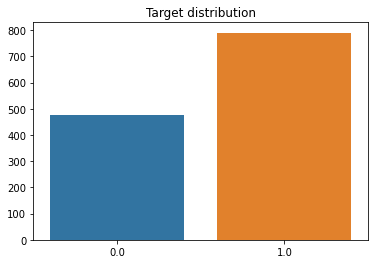

In [13]:
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Target distribution')
plt.show()

In [14]:
# -- > Slight imbalance (use a custom Loss Function)

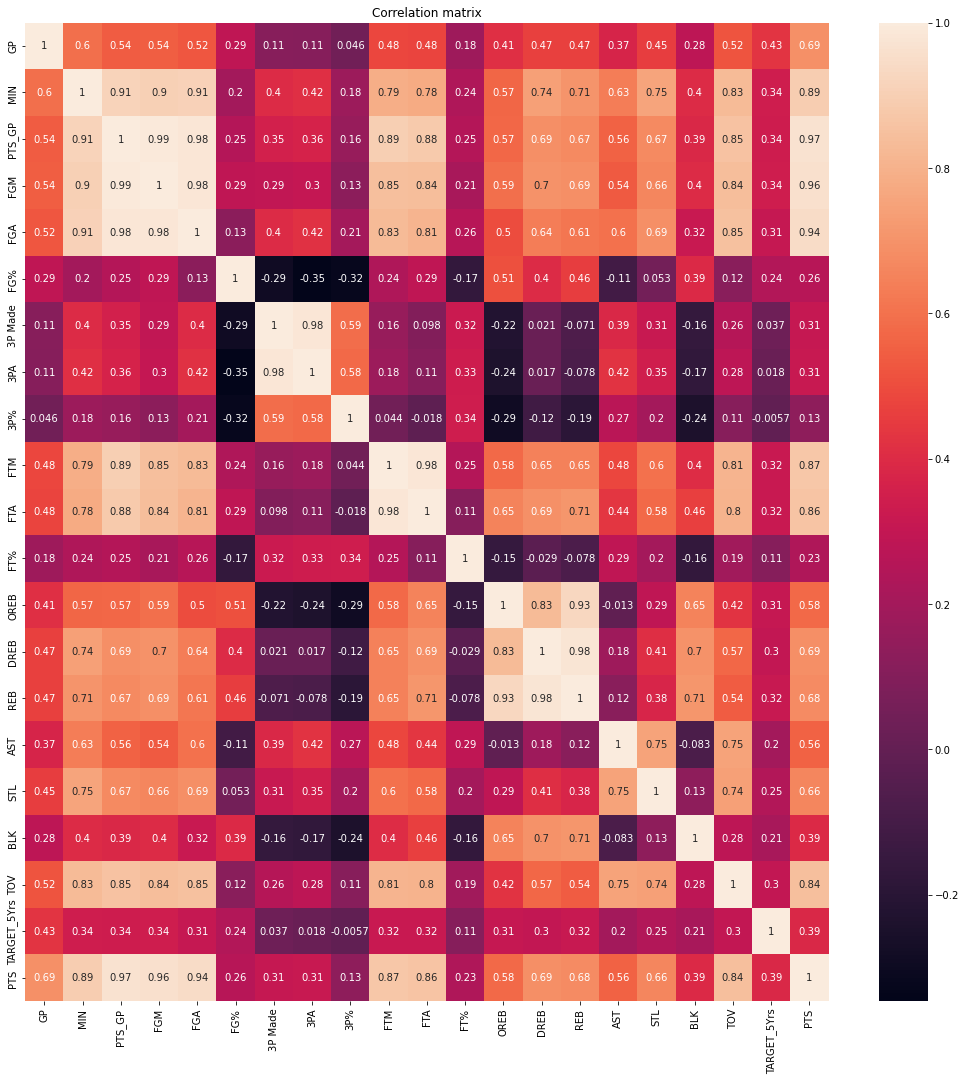

In [15]:
plt.figure(figsize=(18,18))
# Get correlation matrix
corr_matrix = df.corr()
# plot correlation matri
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation matrix')
plt.show()

In [16]:
pd.set_option('display.max_columns', 500)
df.head()

,Name,GP,MIN,PTS_GP,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0,266.4
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0,252.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0,384.8
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0,330.6
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0,216.0


## Modeling

In [17]:
def preprocessing_pipe(train_x, test_x):
    sc = sp.StandardScaler()
    train_x_scaler = pd.DataFrame(sc.fit_transform(train_x), columns=train_x.columns)
    test_x_scaler = pd.DataFrame(sc.fit_transform(test_x), columns=test_x.columns)
    return train_x_scaler, test_x_scaler

In [18]:
def build_train_model(df, preprocessing_pipe, model, verbose=False):
    results = pd.DataFrame(columns=['Accuracy', 'AUC', 'F1', 'Precision', 'Recall'])
    kf = ms.StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
    x = df.drop(['TARGET_5Yrs', 'Name'], axis=1)
    y = df['TARGET_5Yrs']
    
    for train_index, test_index in kf.split(x, y):
        train_x, test_x = x.iloc[train_index], x.iloc[test_index]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        train_x_scaled, test_x_scaled = preprocessing_pipe(train_x, test_x)
        model.fit(train_x_scaled, train_y)
        test_y_pred = model.predict(test_x_scaled)
        test_y_pred_proba = model.predict_proba(test_x_scaled)[:, -1]
        
        if verbose:
            print("Confusion_matrix:\n", sm.confusion_matrix(test_y, test_y_pred))
            print('Classification_report:\n', sm.classification_report(test_y, test_y_pred))
            print('ROC_AUC_score:\n', sm.roc_auc_score(test_y, test_y_pred))
            print('F1_score:', sm.f1_score(test_y, test_y_pred))
            print('Accuracy_score;', sm.accuracy_score(test_y, test_y_pred))
            print('Precision:', sm.precision_score(test_y, test_y_pred))
            print('Recall:', sm.recall_score(test_y, test_y_pred))
            
            fpr, tpr, thresholds = roc_curve(test_y, test_y_pred)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            
            precision, recall, thresholds = precison_recall_curve(test_y, test_y_pred_proba)
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision Recall Curve')
            plt.show()
            
        results.loc[len(results)] =  [sm.accuracy_score(test_y, test_y_pred), sm.roc_auc_score(test_y, test_y_pred), 
                                         sm.f1_score(test_y, test_y_pred), sm.precision_score(test_y, test_y_pred), 
                                         sm.recall_score(test_y, test_y_pred)]
    return model, results
            

In [19]:
model = se.RandomForestClassifier()
model, results = build_train_model(df, preprocessing_pipe, model)
print(results.describe())

       Accuracy       AUC        F1  Precision    Recall
count  5.000000  5.000000  5.000000   5.000000  5.000000
mean   0.722530  0.693484  0.784746   0.760940  0.810127
std    0.013228  0.012293  0.011408   0.007291  0.016136
min    0.707510  0.679780  0.771605   0.753012  0.791139
25%    0.711462  0.682945  0.775385   0.754491  0.797468
50%    0.723320  0.694537  0.785276   0.761905  0.810127
75%    0.731225  0.700866  0.792683   0.764706  0.822785
max    0.739130  0.709294  0.798780   0.770588  0.829114


## Model Explainability

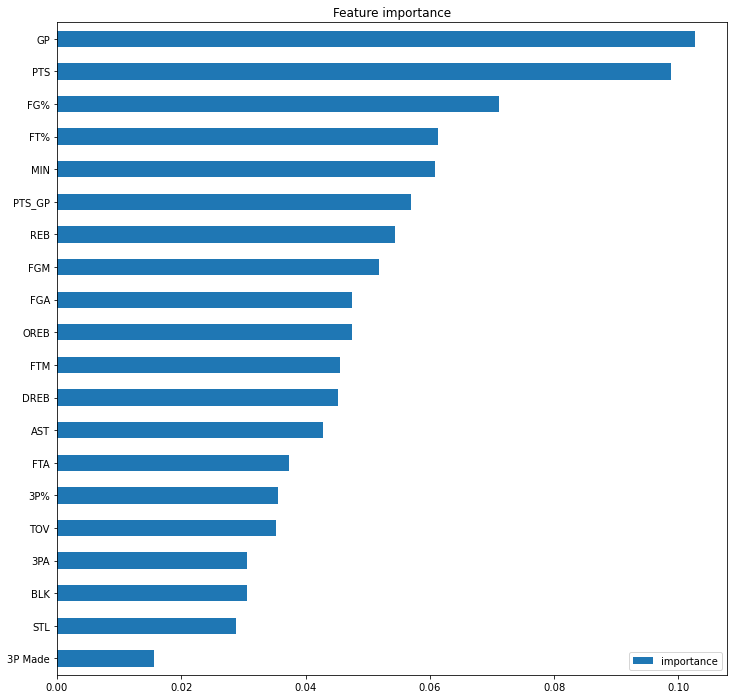

In [20]:
# Feature Importance
x = df.drop(['TARGET_5Yrs', 'Name'], axis=1)
feature_importance = pd.DataFrame(model.feature_importances_, index=x.columns, columns=['importance'])
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.plot(kind='barh', figsize=(12, 12))
plt.title("Feature importance")
plt.show()

In [21]:
from shap import TreeExplainer

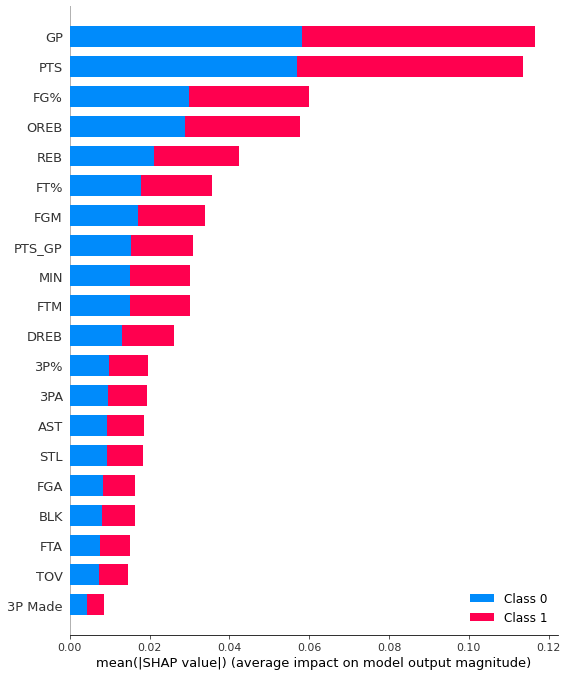

In [22]:
# Shape vaules
x = df.drop(['TARGET_5Yrs', 'Name'], axis=1)
y = df['TARGET_5Yrs']

kf = ms.StratifiedKFold(n_splits=5, random_state=50, shuffle=True)
for train_index, test_index in kf.split(x, y):
    train_x, test_x, train_y, test_y = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

    train_x_scaled, test_x_scaled = preprocessing_pipe(train_x, test_x)

explainer = TreeExplainer(model)
shap_values = explainer.shap_values(test_x_scaled)
shap.summary_plot(shap_values, test_x_scaled)
plt.show()

## Feature engineering

In [23]:
df = pd.read_csv("nba_logreg.csv")

In [24]:
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [25]:
# Improvement 1
df = df.rename({'PTS': 'PTS_GP'}, axis=1)
df['PTS'] = df['PTS_GP'] * df['GP']
df.fillna(0, inplace=True)

df = df.drop_duplicates(subset=['Name'], keep=False)
df.reset_index(drop=True, inplace=True)

In [26]:
# Improvement 2
df = df[['Name', 'PTS', 'GP', 'FGM', 'FG%', 'REB', 'FTM', 'MIN', 'TARGET_5Yrs']]


In [27]:
# Improvement 3
model = se.RandomForestClassifier(class_weight="balanced")

In [28]:
def create_features(relative_to = 'MIN'):
    #Create features list from DataFrame
    features = [col for col in df.columns.values.tolist() if col not in ['TARGET_5Yrs', 'Name']]
    #Create features relative to minutes played
    filtered_features = [col for col in features if '_' not in col and col !=relative_to and '%' not in col]
    new_features = [ col+ '_' + relative_to for col in filtered_features]
    df[new_features] = df[filtered_features].divide(df[relative_to], axis=0)
    return df

In [29]:
df = create_features(relative_to = 'MIN')

In [30]:
df.head()

,Name,PTS,GP,FGM,FG%,REB,FTM,MIN,TARGET_5Yrs,PTS_MIN,GP_MIN,FGM_MIN,REB_MIN,FTM_MIN
0,Brandon Ingram,266.4,36,2.6,34.7,4.1,1.6,27.4,0.0,9.722628,1.313869,0.094891,0.149635,0.058394
1,Andrew Harrison,252.0,35,2.0,29.6,2.4,2.6,26.9,0.0,9.368030,1.301115,0.074349,0.089219,0.096654
2,JaKarr Sampson,384.8,74,2.0,42.2,2.2,0.9,15.3,0.0,25.150327,4.836601,0.130719,0.143791,0.058824
3,Malik Sealy,330.6,58,2.3,42.6,1.9,0.9,11.6,1.0,28.500000,5.000000,0.198276,0.163793,0.077586
4,Matt Geiger,216.0,48,1.6,52.4,2.5,1.3,11.5,1.0,18.782609,4.173913,0.139130,0.217391,0.113043


In [31]:
model, results = build_train_model(df, preprocessing_pipe, model)
print(results.describe())

       Accuracy       AUC        F1  Precision    Recall
count  5.000000  5.000000  5.000000   5.000000  5.000000
mean   0.705138  0.668648  0.775462   0.739543  0.815190
std    0.021395  0.024344  0.015552   0.017461  0.016983
min    0.671937  0.628215  0.753709   0.709497  0.791139
25%    0.695652  0.663991  0.764526   0.739645  0.803797
50%    0.715415  0.679813  0.783133   0.747126  0.822785
75%    0.719368  0.682978  0.786787   0.748571  0.829114
max    0.723320  0.688241  0.789157   0.752874  0.829114


In [59]:
from lightgbm import LGBMClassifier

### Hyperparameters optimisation

In [75]:
def objective(trial):
    x = df.drop(['TARGET_5Yrs', 'Name'], axis=1)
    y = df['TARGET_5Yrs']
    kwargs = {}
    classifier = trial.suggest_categorical('classifier', ['LogisticRegression', 'RandomForest', 'lightGBM'])
    if classifier == 'LogisticRegression':
        penalty = trial.suggest_categorical('penality', ['l2', 'none'])
        class_weight = 'balanced'
        model = lm.LogisticRegression(penalty=penalty, **kwargs)
    elif classifier == 'RandomForest':
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        n_estimators = trial.suggest_int('n_estimators', 10, 200, log=True)
        model = se.RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    elif classifier =='lightGBM':
        num_leaves = trial.suggest_int('num_leaves',2, 64, log=True)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        n_estimators = trial.suggest_int('n_estimators', 10, 200, log=True)
        model = LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, n_estimators=n_estimators)
    mean_score=0
    
    kf = ms.StratifiedKFold(n_splits=5, random_state=50, shuffle=True)
    for train_index, test_index in kf.split(x, y):
        train_x, test_x, train_y, test_y = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        
        train_x_scaled, test_x_scaled = preprocessing_pipe(train_x, test_x)
        model.fit(train_x_scaled, train_y)
        
        test_y_pred = model.predict(test_x_scaled)
        test_y_pred_proba = model.predict_proba(test_x_scaled)[:, 1]
        
        mean_score += sm.roc_auc_score(test_y, test_y_pred_proba)/5
        
    return mean_score

In [76]:
import optuna

In [77]:
# Create an optuna object 
study = optuna.create_study(direction='maximize')
# Run the study
study.optimize(objective, n_trials=100)
# Get the best model
best_model = study.best_trial
# Print the best model
print("Best model:{}".format(best_model.params))
# Print the best model's score 
print("Best model's score:{}".format(best_model.value))
# Print the best model's params
print("Best model's params:{}".format(best_model.params))
# Print the best model's number of trials
print("Best model's number of trials:".format(best_model.number))

[I 2022-08-17 15:35:54,559] A new study created in memory with name: no-name-771985e2-b7c9-4df2-be94-c176731fdfa9
[I 2022-08-17 15:35:54,898] Trial 0 finished with value: 0.7498001332445037 and parameters: {'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 14}. Best is trial 0 with value: 0.7498001332445037.
[I 2022-08-17 15:35:55,957] Trial 1 finished with value: 0.7494536975349766 and parameters: {'classifier': 'RandomForest', 'max_depth': 18, 'n_estimators': 70}. Best is trial 0 with value: 0.7498001332445037.
[I 2022-08-17 15:35:56,153] Trial 2 finished with value: 0.7722051965356429 and parameters: {'classifier': 'LogisticRegression', 'penality': 'none'}. Best is trial 2 with value: 0.7722051965356429.
[I 2022-08-17 15:35:56,284] Trial 3 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:35:56,750] Trial 4 finished with value: 0.768347768154563

[I 2022-08-17 15:36:06,113] Trial 38 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:07,123] Trial 39 finished with value: 0.7675549633577615 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 78}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:07,319] Trial 40 finished with value: 0.7618520986009327 and parameters: {'classifier': 'lightGBM', 'num_leaves': 11, 'max_depth': 11, 'n_estimators': 19}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:07,474] Trial 41 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:07,596] Trial 42 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with val

[I 2022-08-17 15:36:15,396] Trial 77 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:15,541] Trial 78 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:15,665] Trial 79 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:15,808] Trial 80 finished with value: 0.7666422385076616 and parameters: {'classifier': 'lightGBM', 'num_leaves': 4, 'max_depth': 25, 'n_estimators': 28}. Best is trial 3 with value: 0.7738174550299801.
[I 2022-08-17 15:36:15,951] Trial 81 finished with value: 0.7738174550299801 and parameters: {'classifier': 'LogisticRegression', 'penality': 'l2'}. Best is trial 3 with value: 0.7738174

Best model:{'classifier': 'LogisticRegression', 'penality': 'l2'}
Best model's score:0.7738174550299801
Best model's params:{'classifier': 'LogisticRegression', 'penality': 'l2'}
Best model's number of trials:
